<a href="https://colab.research.google.com/github/0ginny/TIL/blob/main/240502_lec46_CodeChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [24]:
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-24-148c0f20c5da>:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [13]:
N = 50
m = 2
x = torch.randn(N,1)
y = m * x + torch.randn(N,1) /2

In [48]:
def gen_points(N,m):
    x = torch.randn(N,1)
    y = m * x + torch.randn(N,1) /2
    return x, y

In [15]:
class ANN():
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(1,1),
            nn.ReLU(),
            nn.Linear(1,1)
        )

    def compile(self,learningRate = 0.05):

        self.optimizer = torch.optim.SGD(self.model.parameters(),lr = learningRate)
        self.lossfun = nn.MSELoss()

    def train(self,x,y,numepochs):

        losses = torch.zeros(numepochs)
        # model prediction

        for epoch in range(numepochs):

            yHat = self.model(x)

            # compute loss
            loss = self.lossfun(yHat,y) # 예측값과 비교값 입력
            losses[epoch] = loss # loss 저장

            # pack propergation # 나중에 이어서
            self.optimizer.zero_grad() # 일단 옵티마이저를 초기화해야해??
            loss.backward()
            self.optimizer.step()
        return losses

    def predict(self,x):
        return self.model(x)

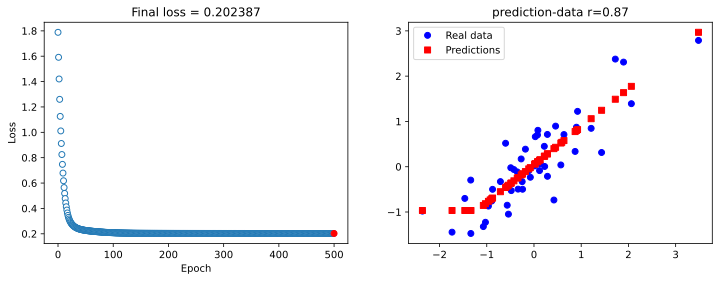

In [51]:
# 한번 실행
N = 50
m = 0.8
numepochs = 500

x, y = gen_points(N,m)
ann = ANN()
ann.compile()
losses = ann.train(x,y,numepochs)
predictions = ann.predict(x)

testloss = (predictions-y).pow(2).mean()

plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.plot(numepochs,testloss.detach(),'ro')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final loss = %g' %testloss.item())

# plot the data
plt.subplot(122)
plt.plot(x,y,'bo',label='Real data')
plt.plot(x,predictions.detach(),'rs',label='Predictions')
plt.title(f'prediction-data r={np.corrcoef(y.T,predictions.detach().T)[0,1]:.2f}')
plt.legend()
plt.show()

가끔 학습이 안되는 경우는 local minimum에 갇히게 되었을 때, 더이상 학습이 없어서 이상한 값으로 고정이 돼.

In [55]:
ms = torch.linspace(-2,2,21)
N = 50
numepochs = 500
numExps = 10
# initialize output matrix
results = np.zeros((len(ms),numExps,2))


for mi in range(len(ms)):
    for Ne in range(numExps) :
        x, y = gen_points(N,ms[mi])

        ann = ANN()
        ann.compile()

        losses = ann.train(x,y,numepochs)
        predictions = ann.predict(x).detach()

            # store the final loss and performance
        results[mi,Ne,0] = losses[-1]
        results[mi,Ne,1] = np.corrcoef(y.T,predictions.T)[0,1]



In [56]:
# 극소점에 빠진 경우를 0으로 초기화
results[np.isnan(results)] = 0

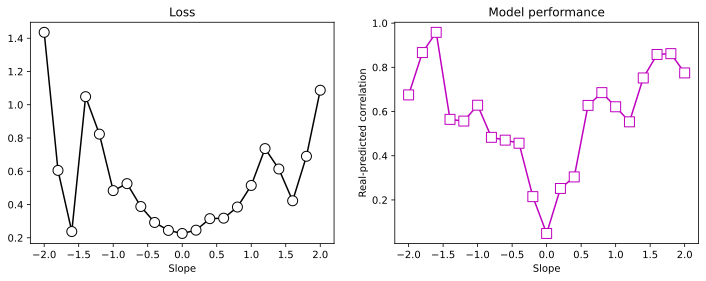

In [57]:
# plot the results!

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(ms,np.mean(results[:,:,0],axis=1),'ko-',markerfacecolor='w',markersize=10)
ax[0].set_xlabel('Slope')
ax[0].set_title('Loss')

ax[1].plot(ms,np.mean(results[:,:,1],axis=1),'ms-',markerfacecolor='w',markersize=10)
ax[1].set_xlabel('Slope')
ax[1].set_ylabel('Real-predicted correlation')
ax[1].set_title('Model performance')

plt.show()

왜 손실값은 기울기가 가파르면 더 커질까? 심지어 정확도는 더 높을 때도

이는 기울기가 커지면, 평균에서 해당 지점까지의 차도 커지기 때문에 그 제곱의  당연히 손실이 커진다.

이 의미는, loss 비교는 같은 데이터 셋에서만 유의미하다.

만약 다른 데이터 셋에서도 같이 비교를 하기 위해선 정규화(스케일링)이 반드시 필요하다.


discussion 2. 왜 slope가 0에 가까울 수록 정확도는 줄어들까?

기울기가 작다면, y값의 결과에 x가 기여하는 정도가 줄어든다는 의미야. 그래서 모델은 y값에 대한 덜 유용한 정보로 학습을 하기 때문에 정확도가 줄어드는 거지.

이것의 시사하는 바는, 딥러닝은 값의 원리를 파악해서 예측하는 것이 아니라, 단순히 변수간의 관계를 학습하는 방법이야.